In [1]:
import pandas as pd
import numpy as np
import torch
import os
from tqdm.notebook import tqdm
from utils import load_data, Environment, DQN, ReplayMemory, get_select_action_fn, get_optimization_fn, save_model_state
from matplotlib import pyplot as plt

In [2]:
ACTION_STEP = 50
CHECKPOINT_BASE = 'checkpoints/agent_{}'.format(ACTION_STEP)
TARGET_UPDATE = 10

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
train, test = load_data()

In [5]:
env = Environment(train, max_loss=1, action_step=ACTION_STEP)

In [6]:
policy_net = DQN(env.n_actions, dropout=0.3).to(device)
target_net = DQN(env.n_actions, dropout=0.3).to(device)
target_net.load_state_dict(policy_net.state_dict())

<All keys matched successfully>

In [7]:
optimizer = torch.optim.Adam(policy_net.parameters(), lr=1e-3)

In [8]:
memory = ReplayMemory(10000)

In [9]:
select_action = get_select_action_fn(policy_net, env.n_actions, device, eps_start=0.9, eps_end=0.4, eps_decay=300)
optimize_model = get_optimization_fn(policy_net, target_net, memory, optimizer, device, batch_size=128, gamma=0.999)

In [10]:
num_episodes = 100
episode_durations = []
history_loss = []
history_cost = []

for i_episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.restart()
    
    target_net.eval()
    policy_net.train()
    
    episode_loss = 0
    episode_cost = 0

    for t in range(10000):
        # Select and perform an action
        action_idx = select_action(state, env.curr_step)
        next_state, cost, done, _ = env.step(action_idx)
        episode_cost += cost
        
        # Store the transition in memory
        memory.push(
            state, 
            action_idx, 
            next_state, 
            cost
        )
        
        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        loss = optimize_model()
        episode_loss += loss
        #break
        
        if done:
            history_loss.append(episode_loss)
            history_cost.append(episode_cost)
            episode_durations.append(t + 1)
            break
    
    save_model_state(
            os.path.join(CHECKPOINT_BASE, 'policy_{}.pt'.format(i_episode)), 
            policy_net,
            optimizer, 
            i_episode, 
            history_loss, 
            history_cost, 
            episode_durations
        )
    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')


Complete


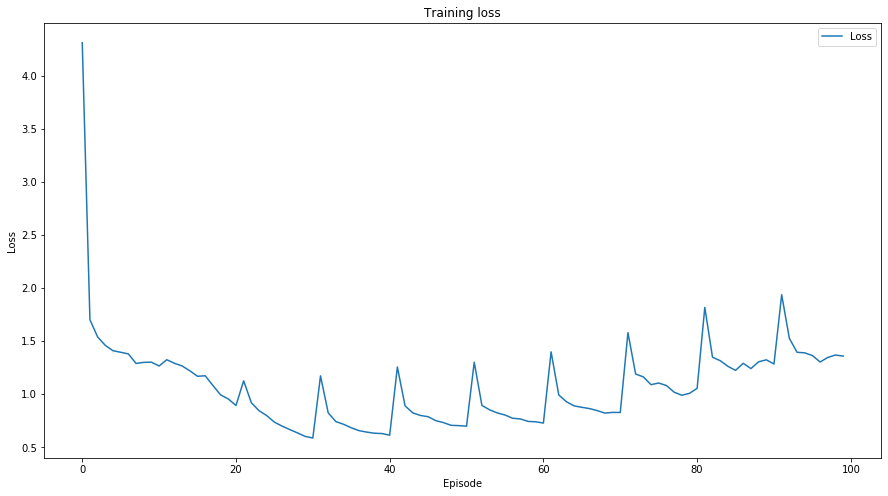

In [11]:
x = np.arange(len(history_loss))
plt.figure(figsize=(15, 8))


plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Training loss')

plt.plot(x, history_loss, label='Loss')

plt.legend()
plt.show()
plt.close()

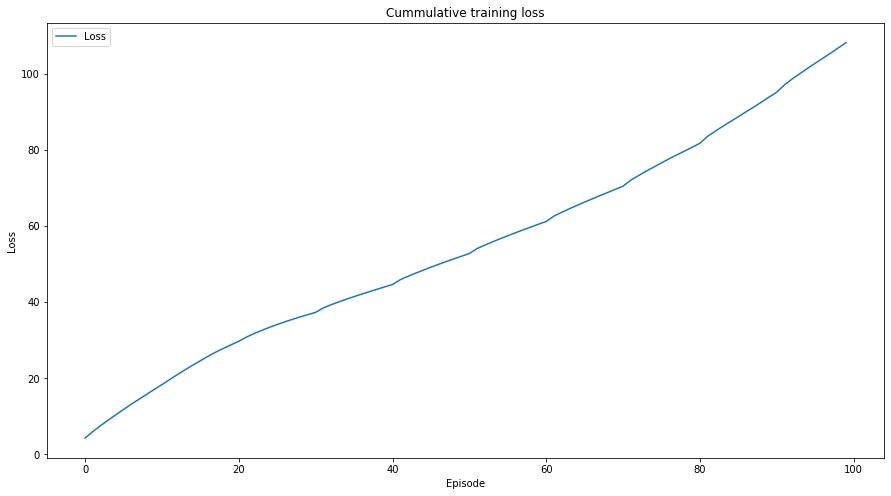

In [12]:
x = np.arange(len(history_loss))
plt.figure(figsize=(15, 8))


plt.xlabel('Episode')
plt.ylabel('Loss')
plt.title('Cummulative training loss')

plt.plot(x, np.cumsum(history_loss), label='Loss')

plt.legend()
plt.show()
plt.close()

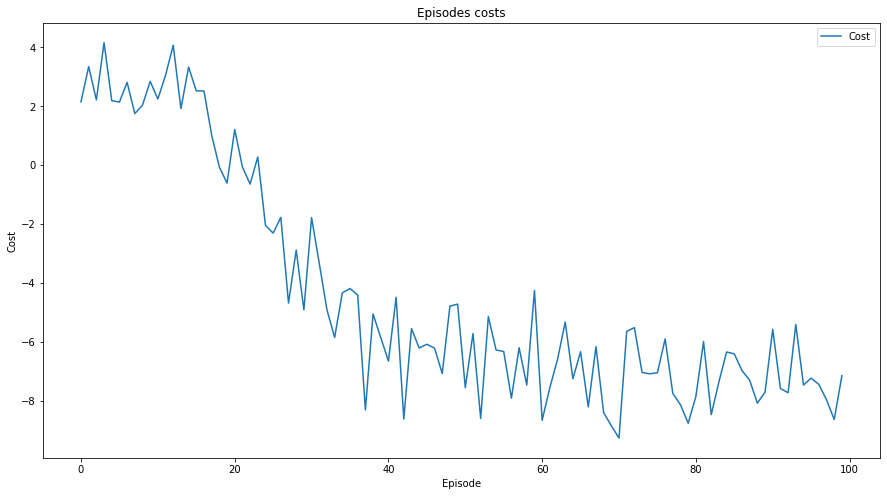

In [13]:
x = np.arange(len(history_loss))
plt.figure(figsize=(15, 8))


plt.xlabel('Episode')
plt.ylabel('Cost')
plt.title('Episodes costs')

plt.plot(x, history_cost, label='Cost')

plt.legend()
plt.show()
plt.close()

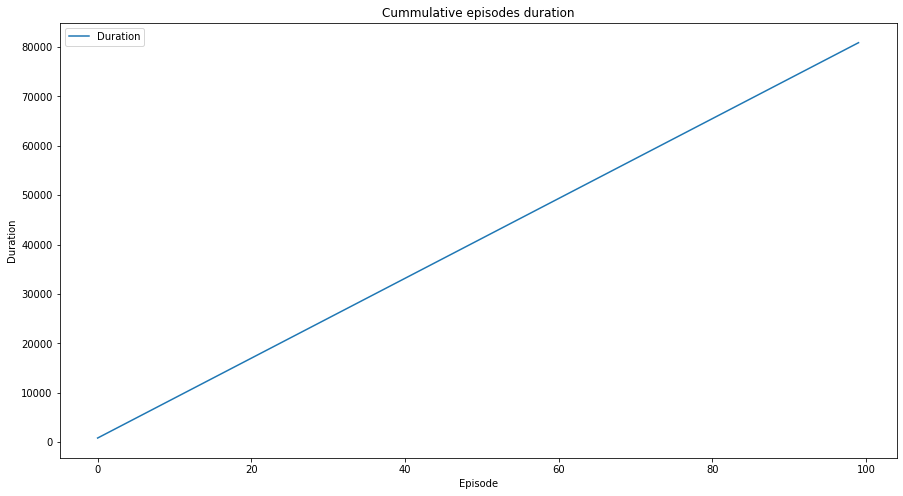

In [14]:
x = np.arange(len(episode_durations))
plt.figure(figsize=(15, 8))


plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Cummulative episodes duration')

plt.plot(x, np.cumsum(episode_durations), label='Duration')

plt.legend()
plt.show()
plt.close()

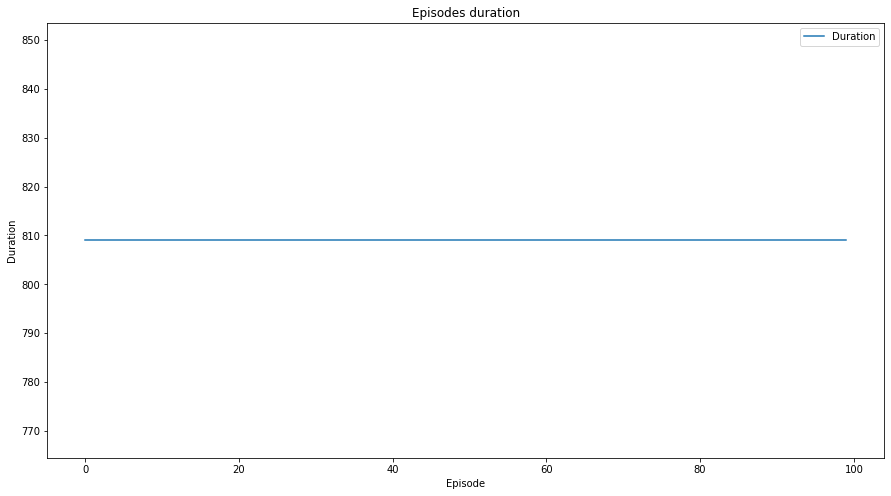

In [15]:
x = np.arange(len(episode_durations))
plt.figure(figsize=(15, 8))


plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Episodes duration')

plt.plot(x, episode_durations, label='Duration')

plt.legend()
plt.show()
plt.close()

In [16]:
print('Last loss:{}   Last cost:{}'.format(
    history_loss[num_episodes - 1],
    history_cost[num_episodes - 1]
))

Last loss:1.3590546174091287   Last cost:-7.156145673702223
